# Future frequency of threshold exceedance under different climate change scenarios

In this chapter the future frequency of threshold exceendance is determined. This is done using different climate change scenarios, which are implemented in the HBV model. The HBV model is calibrated in Chapter 4

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
import seaborn as sns
sns.set()

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

# Choose region and time period: 
Of course we need to change the time period to some future period covered by CMIP

In [3]:
camelsgb_id = "lamah_208082"

In [4]:
experiment_start_date = "2060-08-01T00:00:00Z"
experiment_end_date = "2100-08-31T00:00:00Z"

# CMIP dataset information
The CMIP project is immense... It requires either intimate knowledge of how the climate community works and stores their data, or someone in that community a phonecall away, to make sure you know which data you really want.

In eWaterCycle we use [ESMValTool](https://esmvaltool.org/) to generate forcing, which gives us the oppertunity to on the fly download CMIP (and other climate) data from available ESGF nodes around the world, provided we know exactly "how to ask". As eWaterCycle user you have to provide a dictionary like the one below as input to the ```ewatercycle.forcing.generate()``` to get the data you want.

In [5]:
cmip_dataset =  {
    'project': 'CMIP6',
    'activity': 'ScenarioMIP',
    'exp': 'ssp585',
    'mip': 'day',
    'dataset': 'MPI-ESM1-2-HR',
    'ensemble': 'r1i1p1f1',
    'institute': 'DKRZ',
    'grid': 'gn'
}

#### Set up paths
Below we change the forcing path from ERA5 to CMIP

In [6]:
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

prepared_forcing_path_caravan_central = Path("/data/eurocsdms-data/forcing/lamah_208082/caravan")

# forcing_path_CMIP = Path.home() / "forcing" / camelsgb_id / "CMIP"  
forcing_path_CMIP = Path("/home/thirza/forcing/lamah_208082/CMIP")
forcing_path_CMIP.mkdir(exist_ok=True)

#prepared_forcing_path_ERA5_central = Path("/data/eurocsdms-data/forcing/camelsgb_73010/ERA5")

# Generate CMIP Forcing
In contrast to the first notebook, here we generate the CMIP data (since that is what this notebook is about). Note that the only thing that changes from the ERA5 forcing of the previous notebook is that instead of ```dataset = "ERA5"``` we now pass the dictionary with CMIP information: ```dataset = cmip_dataset```

In [7]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_CMIP,
#     basin_id=camelsgb_id,
# )

In [8]:
# # option two: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

In [9]:
print(camelsgb_forcing)

CaravanForcing(
    start_time='1981-08-01T00:00:00Z',
    end_time='2030-12-31T00:00:00Z',
    directory=PosixPath('/home/thirza/forcing/lamah_208082/caravan'),
    shape=PosixPath('/home/thirza/forcing/lamah_208082/caravan/lamah_208082.shp'),
    filenames={
        'tasmax': 'lamah_208082_1981-08-01_2030-12-31_tasmax.nc',
        'tas': 'lamah_208082_1981-08-01_2030-12-31_tas.nc',
        'tasmin': 'lamah_208082_1981-08-01_2030-12-31_tasmin.nc',
        'Q': 'lamah_208082_1981-08-01_2030-12-31_Q.nc',
        'pr': 'lamah_208082_1981-08-01_2030-12-31_pr.nc',
        'evspsblpot': 'lamah_208082_1981-08-01_2030-12-31_evspsblpot.nc'
    }
)

In [10]:
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])

In [11]:
# # option one: generate forcing:
# CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset=cmip_dataset,
#    start_time=experiment_start_date,
#    end_time=experiment_end_date,
#    shape=camelsgb_forcing.shape,
# )

# # option two: load data that you or someone else generated previously
# #   this is needed because ERA5 forcing data is stored deep in a sub-directory
# load_location = prepared_forcing_path_caravan_central / "work" / "diagnostic" / "script" 
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(Path("/home/thirza/BEPproject/book/esmvaltool_output/ewcrepd9wdj_6j_20250320_093044/work/diagnostic/script"))

In [12]:
print(CMIP_forcing)

LumpedMakkinkForcing(
    start_time='2025-08-01T00:00:00Z',
    end_time='2100-08-31T00:00:00Z',
    directory=PosixPath('/home/thirza/BEPproject/book/esmvaltool_output/ewcrepd9wdj_6j_20250320_093044/work/diagnos
tic/script'),
    shape=PosixPath('/home/thirza/BEPproject/book/esmvaltool_output/ewcrepd9wdj_6j_20250320_093044/work/diagnostic/
script/lamah_208082.shp'),
    filenames={
        'pr': 'CMIP6_MPI-ESM1-2-HR_day_ssp585_r1i1p1f1_pr_gn_2025-2100.nc',
        'tas': 'CMIP6_MPI-ESM1-2-HR_day_ssp585_r1i1p1f1_tas_gn_2025-2100.nc',
        'rsds': 'CMIP6_MPI-ESM1-2-HR_day_ssp585_r1i1p1f1_rsds_gn_2025-2100.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

# Load parameters from calibration
Note that we have to use historic calibration constants for future runs: we don't have observations yet!!

In [13]:
#load calibration constants
#par_0 = np.loadtxt("/data/eurocsdms-data/calibration/calibration_" + camelsgb_id + ".csv", delimiter = ",")
# par_0 = np.loadtxt("/home/rhut/configFiles/calibration" + camelsgb_id + ".csv", delimiter = ",")
# par_0 = [1.46408246e-07, 8.68881909e-01, 1.02507886e+02, 2.20192834e+00,
#        1.05791079e+00, 1.84223360e-01, 1.15943798e+00, 1.59419229e+00,
#        5.97650513e-01]

par_0 = [7.70574780e-07, 1.32351315e+00, 1.00047603e+02, 3.89427105e+00,
       6.66366529e-01, 4.30576783e-02, 1.00508560e+00, 1.94023052e+00,
       4.58706486e-01]

param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
print(list(zip(param_names, np.round(par_0, decimals=3))))

[
    ('Imax', 0.0),
    ('Ce', 1.324),
    ('Sumax', 100.048),
    ('Beta', 3.894),
    ('Pmax', 0.666),
    ('Tlag', 0.043),
    ('Kf', 1.005),
    ('Ks', 1.94),
    ('FM', 0.459)
]

In [14]:
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

# Setting up the model
The only difference with the previous notebook is that here we pass CMIP instead of ERA5 forcing to the model on creation

In [15]:
model = ewatercycle.models.HBV(forcing=CMIP_forcing)

In [16]:
config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)

In [17]:
model.initialize(config_file)

#### Running the model

In [18]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [19]:
model.finalize()

#### Process results

In [20]:
model_output = pd.Series(data=Q_m, name="Modelled discharge", index=time)
model_output.index = model_output.index.tz_localize("UTC")

model_output_filtered = model_output[experiment_start_date:experiment_end_date]

In [21]:
# model_output.plot()
# ds_forcing["Q"].plot(label="Observed discharge")
# plt.legend()
# plt.ylabel("Discharge (mm/d)")

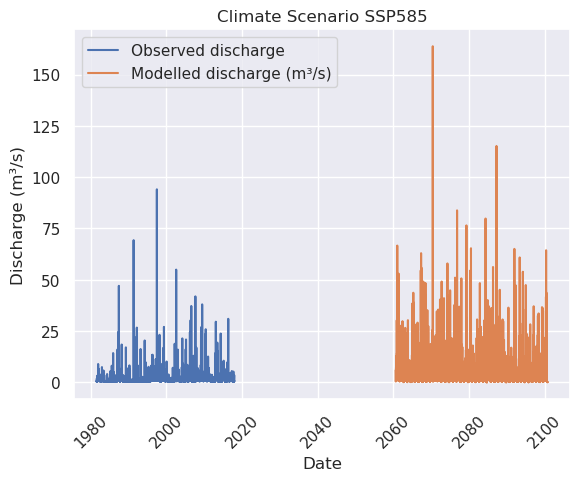

In [22]:
catchment_area = ds_forcing["area"].values


df = pd.DataFrame(model_output_filtered)
model_data = df['Modelled discharge'] * catchment_area * 1000 / (24 * 60 * 60)
(ds_forcing["Q"]* catchment_area * 1000 / (24 * 60 * 60)).plot(label="Observed discharge")

plt.plot(df.index, model_data, label='Modelled discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Climate Scenario SSP585')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()

plt.savefig("/home/thirza/BEPproject/book/EINDRAPPORT/grafiek585discharge.png", dpi=300)
plt.show()

For a mean threshold value of 530 m3/s, the return period is 235.131 years for fit all data

For a mean threshold value of 534 m3/s, the return period is 238.675 years for fit all data

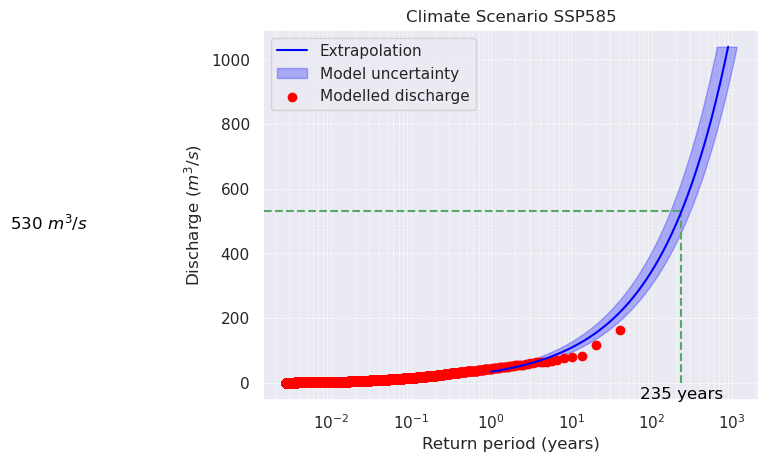

In [31]:
import scipy.stats as stats
import math
from scipy.optimize import curve_fit, fsolve

# Sort data from high to low
sorted_model_data = np.sort(model_data)[::-1]  # Sorteer aflopend


def power_law(x, a, b):
    return a * x ** b

def calculate_return_periods(sorted_model_data):
    n = len(sorted_model_data)
    rank = np.arange(1, n + 1)
    return_periods_days = (n + 1) / rank
    return_periods_years = return_periods_days / 365.25
    
    # Alleen de data voor returnperioden >= 0 behouden
    return_periods_years_subset = return_periods_years[return_periods_years >= 0]
    sorted_data_subset = sorted_model_data[return_periods_years >= 0]

    # Fit de power law functie
    params, _ = curve_fit(power_law, return_periods_years_subset, sorted_data_subset, maxfev=1000)
    a_opt, b_opt = params

    # Maak een fit voor de return period
    x_fit = np.logspace(0.001, np.log(max(return_periods_years_subset))*0.8, 1000)
    y_fit = power_law(x_fit, a_opt, b_opt)

    return x_fit, y_fit, a_opt, b_opt, return_periods_years_subset, sorted_data_subset

x_fit, y_fit, a_opt, b_opt, return_periods_years_subset, sorted_data_subset = calculate_return_periods(sorted_model_data)

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 530
x_value = find_x_for_y(y_target, a_opt, b_opt)
print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

plt.hlines(y_target, xmin=0, xmax=x_value, colors='g', linestyles='dashed')
plt.vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed')
plt.text(x_value, -50, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')  
plt.text(0.000001, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12, color='black')

y_target = 534
x_value = find_x_for_y(y_target, a_opt, b_opt)
print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

plt.plot(x_fit, y_fit, color='blue', label=f'Extrapolation')

uncertainty_percentage = 0.277  # 27.7% uncertainty
x_uncertainty = uncertainty_percentage * x_fit  # Calculate the uncertainty for the x-axis

# Upper and lower bounds for the uncertainty on the x-axis
x_upper_bound = x_fit + x_uncertainty
x_lower_bound = x_fit - x_uncertainty

# Fill the uncertainty region for the x-axis
plt.fill_betweenx(y_fit, x_lower_bound, x_upper_bound, color='blue', alpha=0.277, label="Model uncertainty")

plt.xscale('log')
plt.scatter(return_periods_years_subset, sorted_data_subset, label='Modelled discharge', color='red')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge ($m^3/s$)')
plt.title('Climate Scenario SSP585')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.savefig("/home/thirza/BEPproject/book/EINDRAPPORT/grafiek585distribution.png", dpi=300)
plt.show()

In [32]:
import pickle

# Maak een dictionary met de gegevens die je wilt opslaan, inclusief de naam van het scenario
output_data = {
    'return_periods_years_subset': return_periods_years_subset,
    'sorted_data_subset': sorted_data_subset,
    'x_fit': x_fit,
    'y_fit': y_fit,
    'x_lower_bound': x_lower_bound,
    'x_upper_bound': x_upper_bound,
    'a_opt': a_opt,
    'b_opt': b_opt,
    'df': df,
    'model_data': model_data,
    'ds_forcing':ds_forcing,
    'scenario_name': "SSP585"  # Voeg hier een naam toe voor het scenario
}

# Specificeer het pad naar waar je de data wilt opslaan
output_path = "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario585_data.pkl"  # Pas dit pad aan

# Sla de data op in een pickle-bestand
with open(output_path, "wb") as f:
    pickle.dump(output_data, f)

print(f"Data succesvol opgeslagen in {output_path}")

Data succesvol opgeslagen in /home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario585_data.pkl